In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

# Dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

# EDA

In [3]:
for x, y in tfds.as_numpy(ds_test):
  print('Shape x:', x.shape)  
  print('Shape y:', y)  
  break

Shape x: (28, 28, 1)
Shape y: 4


In [ ]:
unique_y = []
for x, y in tfds.as_numpy(ds_test):
  if not y in unique_y:
    unique_y.append(y)
print(sorted(unique_y))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
max_x = 0
for x, y in tfds.as_numpy(ds_test):
  m = np.max(x)
  max_x = max_x if max_x > m else m 
print(max_x)

255


In [ ]:
y_dist = defaultdict(int)
for x, y in tfds.as_numpy(ds_test):
  y_dist[y] += 1

<BarContainer object of 10 artists>

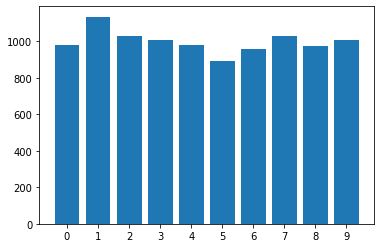

In [ ]:
ax = plt.axes()
plt.xticks(range(0,10))
ax.bar(y_dist.keys(), y_dist.values())

# Preprocessing

In [4]:
def normalize_img(image, label):  
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
test_pred = None
test_y = None
for x, y in tfds.as_numpy(ds_test):
  test_pred = x 
  test_y = y
  break

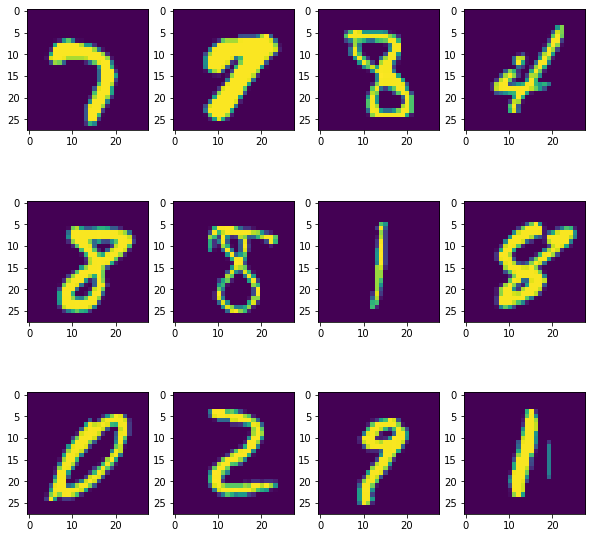

In [39]:
fig, axes = plt.subplots(3,4)
fig.set_figwidth(10)
fig.set_figheight(10)
for i in range(0,12):
  axes[i//4, i%4].imshow(test_pred[i+102].squeeze())

# Model and Training

In [6]:
strategy = tf.distribute.get_strategy()

In [7]:
with strategy.scope():
  input_layer = layers.Input(shape=(28,28,1))
  x = layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform')(input_layer)
  x = layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform')(x)
  x = layers.MaxPool2D(pool_size=(2,2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
  out = layers.Dense(10, activation='softmax')(x)

  model = Model(inputs=input_layer, outputs=out)
  model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=SparseCategoricalAccuracy())

In [8]:
es = EarlyStopping(monitor='val_loss' ,patience=5, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/MNIST-Model/mnist-model_cnn.h5', monitor='val_loss', verbose=1, save_weights_only=True, mode='min')

In [11]:
model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
    callbacks=[es, mc],
)

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0585 - val_sparse_categorical_accuracy: 0.9819

Epoch 00001: saving model to drive/MyDrive/MNIST-Model/mnist-model_cnn.h5
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0558 - val_sparse_categorical_accuracy: 0.9832

Epoch 00002: saving model to drive/MyDrive/MNIST-Model/mnist-model_cnn.h5
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0660 - val_sparse_categorical_accuracy: 0.9814

Epoch 00003: saving model to drive/MyDrive/MNIST-Model/mnist-model_cnn.h5
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0658 - val_sparse_categorical_accuracy: 0.9816

Epoch 00004: saving model to drive/MyDrive/MNIST-Model

In [12]:
model.load_weights('drive/MyDrive/MNIST-Model/mnist-model_cnn.h5')

In [13]:
model.save('drive/MyDrive/MNIST-Model/mnist-model_cnn.h5')

In [14]:
test_pred = None
test_y = None
for x, y in tfds.as_numpy(ds_test):
  test_pred = x 
  test_y = y
  break

In [15]:
test_pred.shape

(128, 28, 28, 1)

Prediction: 7
Label: 7


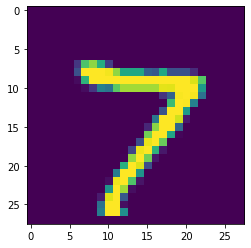

In [23]:
index = 5
plt.imshow(test_pred[index].squeeze())
preds = model.predict(np.expand_dims(test_pred[index],axis=0))
print('Prediction:', np.argmax(preds))
print('Label:', test_y[index])